## Test per progetto AI

E' necessario caricare i file roads_small.json e nodes_small.json

In [1]:
import json
import numpy as np
import matplotlib.pyplot as plt
import math
import networkx as nx
import random

from datetime import datetime
from datetime import timedelta
from itertools import permutations

In [2]:
!pip install pyvis

  Created wheel for pyvis: filename=pyvis-0.2.0-py3-none-any.whl size=23677 sha256=9df5f84b583b2fcf65049c21fe0f1b8c14698aaf6805d2e3417533949d533d12
  Stored in directory: /root/.cache/pip/wheels/74/ed/a1/9441bf0a9e35efc8351ea92cb62c71c2a604a027b890f970c4
Successfully built pyvis


In [3]:
from pyvis.network import Network

In [4]:
# retrieve dataset

!wget https://raw.githubusercontent.com/KrukDallan/AI-Project/main/code/datasets/new_nodes.json
!wget https://raw.githubusercontent.com/KrukDallan/AI-Project/main/code/datasets/new_roads.json

--2022-05-07 08:20:34--  https://raw.githubusercontent.com/KrukDallan/AI-Project/main/code/datasets/new_nodes.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 99175 (97K) [text/plain]
Saving to: ‘new_nodes.json’

new_nodes.json      100%[===================>]  96.85K  --.-KB/s    in 0.01s   

2022-05-07 08:20:35 (9.28 MB/s) - ‘new_nodes.json’ saved [99175/99175]

--2022-05-07 08:20:35--  https://raw.githubusercontent.com/KrukDallan/AI-Project/main/code/datasets/new_roads.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 131

In [5]:
nodes = json.load(open('new_nodes.json', 'r'))
roads = json.load(open('new_roads.json', 'r'))
print("Num nodes", len(nodes))
print("Num roads", len(roads))

Num nodes 2239
Num roads 10138


In [6]:
np.random.seed(0) # fix the random seed for np
random.seed(0)

Create two maps as lookup tables for the nodes

In [7]:
#create a lookup table for point coordinates
node_coords = {point['id']:tuple(point['coordinates']) for point in nodes} #dictonary initialization with comprehension
coords_node = {tuple(point['coordinates']):point['id'] for point in nodes} #tuples are hashable-> can be key to a dictionary

In [8]:
print(node_coords[roads[11]['p1']]) #retrieve coordinates from node ID

(12.55, 45.59)


A questo punto bisogna generare le query degli utenti:

semplificazione: l'orario non influisce sui tempi di percorrenza -> dipendono solo dalla distanza

Consider each trip as starting or ending in one of the nodes: the function below serves to approximate the closest node on the map

Regular transfer (not related to pendolarism) is modeled as a gaussian random variable with respect to location ($\mu = 15km, \sigma = 10km$)  

In [9]:
# compute distance between two nodes

def compute_distance(x_coord_1, y_coord_1, x_coord_2, y_coord_2):
  x_coord_1 = x_coord_1 * 111.32
  x_coord_2 = x_coord_2 * 111.32
  y_coord_1 = 40075 * math.cos(x_coord_1)/360 * y_coord_1;
  y_coord_2 = 40075 * math.cos(x_coord_2)/360 * y_coord_2;
  dist = math.sqrt((y_coord_1 - y_coord_2)**2 + (x_coord_1 - x_coord_2)**2)
  return dist

In [10]:
def compute_distance(x1, y1, x2, y2) :
  R = 6371e3 #metres
  phi1 = x1 * math.pi/180 # φ, λ in radians
  phi2 = x2 * math.pi/180
  delta_phi = (x2-x1) * math.pi/180
  delta_lambda = (y2-y1) * math.pi/180

  a = math.sin(delta_phi/2) * math.sin(delta_phi/2) + math.cos(phi1) * math.cos(phi2) * math.sin(delta_lambda/2) * math.sin(delta_lambda/2)
  c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a));

  d = R * c #in metres

  return d

In [11]:
# use of networkx, creation of graph

G = nx.Graph()

G.add_nodes_from(range(len(nodes)))
for road in roads :
  n1 = int(road.get("p1"))
  n2 = int(road.get("p2"))
  x_coord_1 = float(nodes[n1].get('coordinates')[0])
  y_coord_1 = float(nodes[n1].get('coordinates')[1])
  x_coord_2 = float(nodes[n2].get('coordinates')[0])
  y_coord_2 = float(nodes[n2].get('coordinates')[1])
  dist = compute_distance(x_coord_1, y_coord_1, x_coord_2, y_coord_2)

  G.add_edge(n1, n2, weight=dist)

G.get_edge_data(0, 1)



{'weight': 1553.904995103261}

In [12]:
def generate_ratings(n_driver):
  mean, std = 3.5, 0.5
  x = np.random.normal(mean, std, size=(n_driver, 1))
  ratings = np.empty(shape = (n_driver, 1))
  for i in range(n_driver):
    y = math.ceil(x[i])
    if (y - x[i] > 0.5) :
      ratings[i] = y - 0.5
    else :
      ratings[i] = y
      
  return ratings


In [13]:
# pool of end points 
# define a random number of destinations (e.g. from 6 to 8)
num_dest = random.randrange(6, 8, 1)
pool_dest = []
for i in range(num_dest):
  rand = random.randrange(len(node_coords))
  id_dest = list(node_coords.keys())[rand]
  coord_dest = list(node_coords.values())[rand]
  pool_dest.append({'id':id_dest, 'coordinates':coord_dest})

print(pool_dest)

[{'id': 1722, 'coordinates': (12.38, 45.51)}, {'id': 165, 'coordinates': (12.57, 45.48)}, {'id': 1060, 'coordinates': (12.44, 45.61)}, {'id': 2094, 'coordinates': (12.16, 45.51)}, {'id': 1990, 'coordinates': (11.94, 45.33)}, {'id': 1658, 'coordinates': (12.19, 45.24)}, {'id': 1242, 'coordinates': (11.81, 45.44)}]


Minimum path lenght:
- Drivers: 40 km
- Riders: 10 km

In [14]:
def generate_trips(n, gen):
  # needs to define, for each driver/rider, one random starting point, and peak from the pool of destinations a random end points
  trips_start = []
  trips_dest = []
  for i in range(n):
    # start point
    if (gen == 'driver') :
      while True:
        # start point
        rand_s = random.randrange((len(nodes)))
        id_start = list(node_coords.keys())[rand_s]
        # end point
        rand_d = random.randrange(num_dest)
        dest = pool_dest[rand_d]
        dist = nx.shortest_path_length(G, id_start, dest.get('id'), weight='weight')
        if (dist > 40e3) :
          coord_start = list(node_coords.values())[rand_s]
          break
    else :
        while True:
          # start point
          rand_s = random.randrange((len(nodes)))
          id_start = list(node_coords.keys())[rand_s]
          # end point
          rand_d = random.randrange(num_dest)
          dest = pool_dest[rand_d]
          dist = nx.shortest_path_length(G, id_start, dest.get('id'), weight='weight')
          if (dist > 10e3) :
            coord_start = list(node_coords.values())[rand_s]
            break
     
    
    trips_start.append({'id':id_start, 'coordinates':coord_start})
    trips_dest.append(dest)

  return trips_start, trips_dest


In [15]:
def generate_schedules(n):
  
  #time probability mass: how many requests per 2-hour slot in percentage
  time_prob = {   
                  '00:00': 1e-3,
                  '2:00': 1e-3,
                  '4:00': 1e-3,
                  '6:00': 1e-3,
                  '6:30': 5e-3,
                  '7:00': 0.02,
                  '7:30': 0.1,
                  '8:00': 0.1,
                  '8:30': 0.1,
                  '10:00': 0.01,
                  '10:30': 0.01,
                  '12:00': 0.1,
                  '12:30': 0.1,
                  '13:00': 0.1,
                  '14:00': 0.01,
                  '16:00': 0.01,
                  '18:00': 0.1,
                  '18:30': 0.1,
                  '19:00': 0.1,
                  '19:30': 0.02,
                  '20:00': 5e-3,
                  '21:00': 5e-3,
                  '22:00': 1e-3,
  }

  

  times = []
  hours = list(time_prob.keys())
  prob = list(time_prob.values())
  for i in range(n):
    times.append((random.choices(hours, prob)[0]))

  return times

In [16]:
class Driver:
  def __init__(self, id, rating, hour, start_point, end_point):
    self.id = id
    self.rating = rating
    self.hour = hour
    self.start_point = start_point
    self.end_point = end_point

  def __str__(self):
    return "Driver ( id = " + str(self.id) + ", rating = " + str(self.rating) + ", hour = " + self.hour + ", start = " + str(self.start_point) + ", dest = " + str(self.end_point) + ")"

class Rider:
  def __init__(self, id, rating, hour, start_point, end_point):
    self.id = id
    self.rating = rating
    self.hour = hour
    self.start_point = start_point
    self.end_point = end_point

  def __str__(self):
    date_format_str = '%H:%M'
    return "Rider ( id = " + str(self.id) + ", rating = " + str(self.rating) + ", hour = " + self.hour + ", start = " + str(self.start_point) + ", dest = " + str(self.end_point) + ")"

In [17]:
def generate_data():
  # 1- generate n_drivers and n_riders
  # range: start, end, stepsize
  n_drivers = random.randrange(40, 50, 1)
  n_riders = random.randrange(150, 250, 15)
  print("N_drivers: ", n_drivers)
  print("N_riders: ", n_riders)
  # 2 - generate start point and end point for drivers and riders
  trips_start_drivers, trips_dest_drivers = generate_trips(n_drivers, gen='driver')
  trips_start_riders, trips_dest_riders = generate_trips(n_riders, gen='rider')
  # 3 - generate schedules
  drivers_schedule = generate_schedules(n_drivers)
  riders_schedule = generate_schedules(n_riders)
  # 4- generate ratings for drivers and riders
  ratings_d = generate_ratings(n_drivers)
  ratings_r = generate_ratings(n_riders)
  # 5 - parse in a list of objects
  riders = []
  drivers = []
  for i in range(n_riders):
    riders.append( Rider(i, ratings_r[i][0], riders_schedule[i], trips_start_riders[i], trips_dest_riders[i]))

  for i in range(n_drivers):
    drivers.append( Driver(i, ratings_d[i][0], drivers_schedule[i], trips_start_drivers[i], trips_dest_drivers[i]))

  return drivers, riders



In [18]:
drivers, riders = generate_data()

for i in range(10) :
  print(drivers[i])

print("\n\n***********************************************************************\n\n")

for i in range(10) :
  print(riders[i])


N_drivers:  47
N_riders:  180
Driver ( id = 0, rating = 4.5, hour = 19:00, start = {'id': 570, 'coordinates': (11.78, 45.29)}, dest = {'id': 1060, 'coordinates': (12.44, 45.61)})
Driver ( id = 1, rating = 4.0, hour = 12:30, start = {'id': 388, 'coordinates': (12.28, 45.19)}, dest = {'id': 1990, 'coordinates': (11.94, 45.33)})
Driver ( id = 2, rating = 4.0, hour = 8:00, start = {'id': 404, 'coordinates': (12.21, 45.55)}, dest = {'id': 1658, 'coordinates': (12.19, 45.24)})
Driver ( id = 3, rating = 5.0, hour = 19:00, start = {'id': 1352, 'coordinates': (11.88, 45.26)}, dest = {'id': 2094, 'coordinates': (12.16, 45.51)})
Driver ( id = 4, rating = 4.5, hour = 13:00, start = {'id': 837, 'coordinates': (12.6, 45.65)}, dest = {'id': 1990, 'coordinates': (11.94, 45.33)})
Driver ( id = 5, rating = 3.5, hour = 7:30, start = {'id': 255, 'coordinates': (12.3, 45.2)}, dest = {'id': 1242, 'coordinates': (11.81, 45.44)})
Driver ( id = 6, rating = 4.0, hour = 18:00, start = {'id': 1633, 'coordinates':

In [19]:
# use of Dijkstra for shortest path

drivers_path = []
riders_path = []

# 50 km/h
avg_vel = 50
date_format_str = '%H:%M'

for driver in drivers:
  spath = nx.dijkstra_path(G, driver.start_point.get('id'), driver.end_point.get('id'))
  dpath = [{'node' : spath[0], 'hour': driver.hour}]
  dist = 0


  for i in range(1, len(spath)):
    # retrieve distance and convert into km
    
    # distance in km
    dist += (G.get_edge_data(spath[i-1], spath[i]).get('weight')) / 1e3
    time = dist / avg_vel
    time_1 = datetime.strptime(driver.hour, date_format_str)
    time_2 = time_1 + timedelta(hours=time)
    str_time = time_2.strftime(date_format_str)

    dpath.append({'node': spath[i], 'hour':str_time})


  total_dist = nx.shortest_path_length(G, driver.start_point.get('id'), driver.end_point.get('id'), weight='weight')

  drivers_path.append({'id_driver': driver.id, 'shortest_path' : dpath, 'arrival_time': str_time})
  
  #print("Driver #" + str(driver.id) + ": start at " + driver.hour + " , end at " + dpath[len(dpath)-1].get('hour'))
  #print("    -> total dist km: ", total_dist/1e3)


for rider in riders:
  spath = nx.dijkstra_path(G, rider.start_point.get('id'), rider.end_point.get('id'))
  riders_path.append({'id_rider': rider.id, 'shortest_path' : spath})

print(drivers_path[0])
print(riders_path)

{'id_driver': 0, 'shortest_path': [{'node': 570, 'hour': '19:00'}, {'node': 569, 'hour': '19:01'}, {'node': 851, 'hour': '19:02'}, {'node': 486, 'hour': '19:10'}, {'node': 115, 'hour': '19:26'}, {'node': 69, 'hour': '19:30'}, {'node': 396, 'hour': '19:31'}, {'node': 397, 'hour': '19:42'}, {'node': 70, 'hour': '19:44'}, {'node': 1940, 'hour': '19:45'}, {'node': 788, 'hour': '19:46'}, {'node': 787, 'hour': '19:49'}, {'node': 888, 'hour': '19:54'}, {'node': 107, 'hour': '19:56'}, {'node': 108, 'hour': '19:57'}, {'node': 1488, 'hour': '19:59'}, {'node': 1491, 'hour': '20:00'}, {'node': 1676, 'hour': '20:01'}, {'node': 246, 'hour': '20:03'}, {'node': 247, 'hour': '20:05'}, {'node': 539, 'hour': '20:06'}, {'node': 1667, 'hour': '20:08'}, {'node': 67, 'hour': '20:09'}, {'node': 44, 'hour': '20:11'}, {'node': 20, 'hour': '20:12'}, {'node': 21, 'hour': '20:14'}, {'node': 60, 'hour': '20:16'}, {'node': 58, 'hour': '20:17'}, {'node': 59, 'hour': '20:19'}, {'node': 61, 'hour': '20:21'}, {'node': 9

In [20]:
def min_distance (shortest_path_driver, rider) :
  min_distance = float('inf')
  xr = rider.start_point.get('coordinates')[0]
  yr = rider.start_point.get('coordinates')[1]
  for node in shortest_path_driver :
    id = node.get('node')
    x1 = nodes[id].get('coordinates')[0]
    x2 = nodes[id].get('coordinates')[1]
    dist = compute_distance(x1, x2, xr, yr)
    if dist < min_distance :
      min_distance = dist

  return min_distance


In [21]:
# find matching: since we assumed drivers and riders having same dest
# first: filter the total of drivers and riders

drivers_match = [{} for _ in range(len(drivers))]

# couple drivers and riders with same dest and similar hours

for driver in drivers :
  drivers_match[driver.id] = {'id_driver' : driver.id, 'list_of_riders' : []}
  for rider in riders :
    dhour_start = datetime.strptime(driver.hour, date_format_str)
    dhour_end = datetime.strptime(drivers_path[driver.id].get('arrival_time'), date_format_str)
    rhour = datetime.strptime(rider.hour, date_format_str)

    #print("min distance: " , min_distance(drivers_path[driver.id].get('shortest_path'), rider))

    # filter per
    # 1- same dest
    # 2- simil hour
    # 3- minimum distance from rider and shortest path <= 30 km
    if driver.end_point.get('id') == rider.end_point.get('id') and ((dhour_start - timedelta(minutes=30)) <= rhour <= (dhour_end + timedelta(minutes=30)))  :
      drivers_match[driver.id].get('list_of_riders').append(rider.id)
  



In [22]:
def preference_list_drivers(drivers_match) :

  preferences = [{} for _ in range(len(drivers))]

  for driver in drivers :
    pref_dict = {}
    for r in drivers_match[driver.id].get('list_of_riders') :
      rider = riders[r]     
      min_dist = min_distance(drivers_path[driver.id].get('shortest_path'), rider)
      if min_dist <= 35e3 :
        # 0.4 * rating + 0.6 * distance in kms
        measure =  0.4*rider.rating + 0.6*(min_dist/1e3)
        pref_dict[rider.id] = measure

    # sort list
    preferences[driver.id] = {'id_driver' : driver.id, 'list_of_riders' : list(dict(sorted(pref_dict.items(), key=lambda item: item[1])))}

    
    
  return preferences



In [23]:
def preference_list_riders(list_of_riders) :

  preferences = [{} for _ in range(len(riders))]

  pref = [ {} for _ in range(len(riders))]

  # build the lists

  for driver in drivers:
    for r in drivers_match[driver.id].get('list_of_riders') :
      rider = riders[r]
      min_dist = min_distance(drivers_path[driver.id].get('shortest_path'), rider)
      if min_dist <= 35e3 :
        pref[rider.id][driver.id] = driver.rating

      
      

  #sort the lists

  for i in range(len(riders)):
    preferences[i] = {'id_rider' : i, 'list_of_drivers' : list(dict(sorted(pref[i].items(), key=lambda item: item[1])))} 
  
  return preferences

# Start of main algorithm

In [24]:
# 1- get path from Steiner tree (first option: compute shortest path)

# 2 - compute preference list of drivers

#print(drivers_match[0].get('list_of_riders'))

print(preference_list_drivers(drivers_match))

print("\n************************************\n")

# 3 - compute preference list of riders

print(preference_list_riders(drivers_match))

[{'id_driver': 0, 'list_of_riders': [111, 85, 78, 8, 18, 2, 153]}, {'id_driver': 1, 'list_of_riders': [86, 19, 54, 84, 13]}, {'id_driver': 2, 'list_of_riders': [159, 167, 71, 72, 103, 176, 4]}, {'id_driver': 3, 'list_of_riders': [154]}, {'id_driver': 4, 'list_of_riders': [86, 54, 13]}, {'id_driver': 5, 'list_of_riders': [58, 5, 21, 152, 3, 105, 34, 149]}, {'id_driver': 6, 'list_of_riders': [143, 25, 50, 157, 178, 38]}, {'id_driver': 7, 'list_of_riders': [165, 155, 140, 131, 96, 145, 124]}, {'id_driver': 8, 'list_of_riders': [63, 130, 53, 90, 177, 139, 104]}, {'id_driver': 9, 'list_of_riders': [83, 31, 74, 122, 20, 147]}, {'id_driver': 10, 'list_of_riders': [63, 53, 177, 130, 104, 90, 139]}, {'id_driver': 11, 'list_of_riders': [41, 67, 109, 28, 33, 76]}, {'id_driver': 12, 'list_of_riders': [24, 162, 156, 68, 170, 52, 118]}, {'id_driver': 13, 'list_of_riders': [131, 165, 155, 140, 96, 145, 124]}, {'id_driver': 14, 'list_of_riders': [72, 159, 71, 103]}, {'id_driver': 15, 'list_of_riders':

In [25]:
# make Network show itself with repr_html
def net_repr_html(self):
  nodes, edges, heading, height, width, options = self.get_network_data()
  html = self.template.render(height=height, width=width, nodes=nodes, edges=edges, options=options)
  return html

Network._repr_html_ = net_repr_html

In [28]:
# pyvis part
def draw_networkx(nx_graph, show_edge_weights=False):
    from pyvis.network import Network
    nt = Network("500px", "500px", notebook=True)
    nt.from_nx(nx_graph, show_edge_weights=show_edge_weights)
    nt.bgcolor = '#ffffff'
    return nt

In [ ]:
# visualize Graph
draw_networkx(G)

In [30]:
# create file input.dat (obsolete (?))
f = open("input.dat", "w")
content = "DIMENSION : " + str(len(nodes)) + "\n"
content += "DRIVERS : " + str(len(drivers)) + "\n"
content += "RIDERS : " + str(len(riders)) + "\n"
content += "NODE_COORD_SECTION\n"
for node in nodes :
  content += str(node.get("id")) + " " + str(node.get("coordinates")[0]) + " " + str(node.get("coordinates")[1]) + "\n"
content += "ROADS_SECTION\n"
for road in roads :
  content += str(road.get("p1")) + " " + str(road.get("p2")) + "\n"
content += "DRIVERS_STARTING_COORD\n"
for driver in drivers:
  content += str(driver.start_point.get("id")) + " " + str(driver.start_point.get("coordinates")[0]) + " " + str(driver.start_point.get("coordinates")[1]) + "\n"
content += "DRIVERS_DESTINATION_COORD\n"
for driver in drivers:
  content += str(driver.end_point.get("id")) + " " + str(driver.end_point.get("coordinates")[0]) + " " + str(driver.end_point.get("coordinates")[1]) + "\n"
content += "RIDERS_STARTING_COORD\n"
for rider in riders:
  content += str(rider.start_point.get("id")) + " " + str(rider.start_point.get("coordinates")[0]) + " " + str(rider.start_point.get("coordinates")[1]) + "\n"
content += "RIDERS_DESTINATION_COORD\n"
for rider in riders:
  content += str(rider.end_point.get("id")) + " " + str(rider.end_point.get("coordinates")[0]) + " " + str(rider.end_point.get("coordinates")[1]) + "\n"
content += "EOF"
f.write(content)
f.close()

## Stable matching module

Stable matching is modeled after the Hospital-Resident problem, where drivers are modeled as hospitals (their capacity being the number of free seats in the car) and riders are modeled as residents.

We use the open source ```matching``` library, originally released under MIT license by Cardiff University researcher Henry Wilde. https://github.com/daffidwilde/matching

Make sure to install ```matching```: (https://matching.readthedocs.io/en/latest/tutorials/installation.html)

```matching``` is also available through **Conda forge**

In [31]:
!pip install matching


In [32]:
from matching.games import HospitalResident

lone_drivers = {dic["id_driver"] for dic in preference_list_drivers(drivers_match) if len(dic['list_of_riders'])==0}
stranded_riders = {dic["id_rider"] for dic in preference_list_riders(drivers_match) if len(dic['list_of_drivers'])==0}

print("n° of stranded riders:", len(stranded_riders), '\n\n')

d = {dic["id_driver"]:dic["list_of_riders"] for dic in preference_list_drivers(drivers_match) if len(dic['list_of_riders'])>0} #drivers
r = {dic["id_rider"]:dic["list_of_drivers"] for dic in preference_list_riders(drivers_match) if len(dic['list_of_drivers'])>0} #riders
capacities = {driver_id:4 for driver_id in d} #for the sake of simplicity, every driver is able/willing to transport up to 4 people

game = HospitalResident.create_from_dictionaries(r, d, capacities)

matching = game.solve(optimal="hospital") #driver-optimal
print(matching)

n° of stranded riders: 44 


{0: [8, 18], 1: [86, 19, 54, 84], 2: [159, 167, 71, 72], 3: [], 4: [], 5: [58, 5, 21, 152], 6: [143, 25, 50, 157], 7: [165, 131, 124], 8: [63, 130, 53, 90], 9: [], 10: [177, 104, 139], 11: [], 12: [68, 52, 118], 13: [], 14: [103], 15: [13], 16: [171, 116, 66, 56], 17: [147, 36], 18: [47, 11, 117, 99], 19: [15, 174, 126, 115], 20: [83, 31, 74, 122], 21: [178, 38], 22: [], 23: [3, 34, 105], 24: [149, 70, 123, 51], 25: [155, 140, 145, 96], 26: [0, 29, 91, 12], 27: [], 29: [], 30: [153, 49, 85, 78], 31: [161, 42, 9, 87], 32: [106, 95, 146, 60], 33: [62, 46, 166, 163], 34: [120, 41, 144, 175], 35: [59, 176, 4], 36: [], 37: [154], 38: [2, 111], 39: [57, 125, 82, 129], 40: [45, 107, 16], 42: [162, 156, 24, 170], 43: [27, 6, 93, 151], 44: [65, 109], 45: [20], 46: [67, 33, 76, 28]}


In [33]:
matched_riders = set()

for driver in dict(matching):
    if not matching[driver]: #empty list
        lone_drivers.add(driver)
    for x in dict(matching)[driver]:
        matched_riders.add(x.name) #perché python madonna beata non te lo dice ma x è di tipo Player
        
for rid in set(r):
    if rid not in matched_riders:
        stranded_riders.add(rid)

print("lone drivers: ", len(lone_drivers), "/ 47")
print("stranded riders ", len(stranded_riders), "/ 180")

print("\n\n", stranded_riders)

lone drivers:  11 / 47
stranded riders  64 / 180


 {128, 1, 132, 133, 134, 7, 136, 137, 10, 138, 135, 141, 14, 142, 17, 148, 22, 23, 150, 26, 30, 158, 32, 160, 35, 164, 37, 39, 40, 168, 169, 43, 44, 172, 173, 48, 179, 55, 61, 64, 69, 73, 75, 77, 79, 80, 81, 88, 89, 92, 94, 97, 98, 100, 101, 102, 108, 110, 112, 113, 114, 119, 121, 127}


## Create the output file for CPlex (Steiner Tree)

Identify the relevant subset of nodes...

In [34]:
def calc_path(G,point1,point2,path_list):
  tmp=point1
  cost_path=0
  for node in nx.dijkstra_path(G, point1, point2):
    path_list.append(node)
    if tmp==node:
      continue
    cost_path += (G.get_edge_data(tmp, node).get('weight'))
    tmp=node
  path_list.remove(point1)
  return cost_path

In [35]:
test=[]
tot_cost=[]
for driv_id in dict(matching):
    type(driv_id.name)
    tmp = [] #id of start node for driver driv_id
    finish=drivers[driv_id.name].end_point['id']
    cost=nx.dijkstra_path_length(G, drivers[driv_id.name].start_point['id'], finish)
    for node in dict(matching)[driv_id]:                     
        if riders[node.name].start_point['id']!=0:
          cost+=nx.dijkstra_path_length(G, riders[node.name].start_point['id'], finish)
          tmp.append(riders[node.name].start_point['id'])
    tot_cost.append(cost)
    test.append(tmp)

In [66]:
from networkx.linalg.graphmatrix import incidence_matrix
trips_list=[]
driver_opt_list = [] #this will be a list of lists of node IDs e.g. [[1,4,254,45], [2,13]]
best_cost=[]
for driv_id in dict(matching):
    type(driv_id.name)
    tmp = []
    tmp2 = []
    tmp3=[]
    
    origin = drivers[driv_id.name].start_point['id'] #id of start node for driver driv_id
    tmp3.append(node_coords[origin])
    for node in dict(matching)[driv_id]:                     
        if riders[node.name].start_point['id']!=0:
          tmp.append(riders[node.name].start_point['id']) #coords of intermediate points
        
    permutazioni = list(permutations(tmp)) #list of all possible permutation of the riders
    cost_path=math.inf
    i=0
    save_id=0
    
    for id in permutazioni:
      all_path=[]
      all_path.append(origin)
      idx=0
      tmp_cost=0
      begin=origin
      if len(id)!=0:
        while(idx<len(id)): #calculation of the best path from origin to end passing through all the riders associated with the current driver
          tmp_cost +=calc_path(G, begin, id[idx], all_path) #function that saves the hole path
          begin=id[idx]
          idx+=1
          
        tmp_cost += calc_path(G,begin, drivers[driv_id.name].end_point['id'],all_path)

        if tmp_cost<cost_path:
          cost_path=tmp_cost
          save_id=i
          best=[]
          best=all_path 
      else: #costpath and optimal path when the driver has no riders associated
        cost_path = 0
        best=[]
        best.append(origin)
        cost_path += calc_path(G,begin, drivers[driv_id.name].end_point['id'],best) 
       
      i+=1
      if i == math.factorial(len(id)):
        i=0
 
    #print(best)
    for node in best:
      tmp2.append(node)
      tmp3.append(node_coords[node])             
    driver_opt_list.append(tmp2)
    best_cost.append(cost_path)
    trips_list.append(tmp3)
    #print(driver_opt_list)
    #print(cost_path)

print(driver_opt_list[0])
print(best_cost)
print("\n\n\n", len(driver_opt_list))


[570, 1214, 944, 993, 1314, 485, 592, 859, 614, 230, 259, 208, 209, 217, 244, 204, 546, 693, 695, 666, 637, 638, 640, 663, 696, 656, 323, 318, 320, 321, 1127, 332, 1128, 1131, 1170, 1168, 1172, 2074, 1873, 1874, 1872, 1071, 1072, 214, 213, 2145, 2147, 2143, 409, 955, 954, 675, 673, 406, 405, 410, 414, 290, 91, 66, 38, 65, 411, 412, 103, 544, 891, 1187, 162, 349, 173, 170, 171, 1060]
[96197.37567795385, 100524.7041842764, 95456.32792899606, 51714.93644288363, 90078.20338629054, 99537.82503933446, 174070.9760566482, 119366.78265374624, 144715.27978390717, 61255.539404806885, 123339.93123453793, 57664.24828286722, 122805.50646822268, 91691.40026942277, 83594.07587865654, 164544.62619717722, 138352.46718957287, 124555.28620046598, 130293.178580479, 106985.25998447347, 120864.03656472416, 91686.38544569093, 51321.66667011711, 112021.97704719333, 114320.28684135286, 75147.54141623649, 124195.52738953427, 61778.684414561794, 40247.24691315577, 92496.39031391821, 98881.1990286358, 100968.92340

In [37]:
CO2=0.15 #around 150gr of CO2 is emitted by a car in 1km
saved_CO2=[]
for i in range(0,len(best_cost)):
  s_km=0
  s_km=(tot_cost[i]-best_cost[i])/1000
  saved_CO2.append(s_km*CO2)
print(saved_CO2)

[17.70477593234764, 1.5135692500486633, 23.142745425653164, 0.0, 0.0, 13.78068313084536, 38.779168012391814, 21.989191351073636, 35.70330910135998, 0.0, 33.27143155956185, 0.0, 20.469593716757615, 0.0, -1.094624666017932, -3.41632756598414, 29.757703691777035, 22.84891019681364, 19.739086415983085, 4.6409364259981665, 19.90377833917058, 4.185615677637684, 0.0, 0.09076965676731634, 38.0892109749991, 20.878951258637372, 21.678872680611885, 0.0, 0.0, 24.13431812988991, 19.51092715137904, 10.04125147808667, 2.4899201319862114, 12.903820297194999, 11.388639308287622, 0.0, -1.5448406898877547, -0.8709640788644428, 5.794146696274475, 16.89286011284236, 8.950878276559058, 26.673193792893482, -1.8932714075413954, 11.998038648820229, 8.502524263839597]


In [74]:
"""
Returns a (potentially very long) list of coordinates that constitute a bounding box for the points in list_of_coords, with a tolerance of delta
"""
def find_bbox(list_of_coords, delta): 
    zipt = list(zip(*list_of_coords)) #[(long1, long2, ...),(lat1, lat2, ...)]
    min_long = min(zipt[0])-delta
    max_long = max(zipt[0])+delta
    min_lat = min(zipt[1])-delta
    max_lat = max(zipt[1])+delta
    
    ret = [c for c in coords_node if c[0]>= min_long and c[0]<= max_long and c[1]>= min_lat and c[1]<= max_lat]
    return ret

In [77]:
len(find_bbox(trips_list[18], 0)) 

[(12.31, 45.44), (12.27, 45.46), (12.28, 45.5), (12.2, 45.45), (12.2, 45.44), (12.24, 45.51), (12.25, 45.51), (12.26, 45.51), (12.27, 45.5), (12.25, 45.5), (12.25, 45.49), (12.24, 45.5), (12.26, 45.47), (12.26, 45.46), (12.22, 45.48), (12.23, 45.48), (12.23, 45.49), (12.29, 45.5), (12.27, 45.47), (12.24, 45.49), (12.28, 45.51), (12.26, 45.49), (12.27, 45.49), (12.27, 45.55), (12.23, 45.5), (12.23, 45.51), (12.25, 45.52), (12.24, 45.48), (12.27, 45.53), (12.28, 45.53), (12.26, 45.52), (12.29, 45.54), (12.27, 45.54), (12.29, 45.53), (12.3, 45.56), (12.28, 45.55), (12.26, 45.55), (12.22, 45.5), (11.95, 45.42), (11.95, 45.41), (12.05, 45.44), (12.25, 45.53), (12.26, 45.53), (12.24, 45.53), (12.29, 45.51), (12.3, 45.51), (12.3, 45.52), (12.23, 45.55), (12.28, 45.52), (12.31, 45.52), (12.28, 45.49), (12.27, 45.52), (12.27, 45.48), (12.22, 45.52), (12.22, 45.51), (12.26, 45.5), (12.27, 45.56), (12.29, 45.56), (12.25, 45.55), (12.31, 45.56), (12.37, 45.57), (12.3, 45.53), (12.3, 45.54), (12.18

Graph has 2239 nodes with 4266 edges


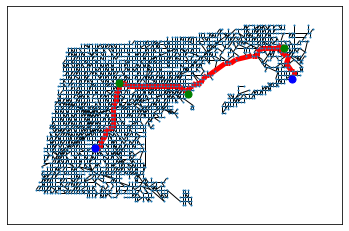

In [97]:
import networkx as nx
import matplotlib.pyplot as plt

routes = list(driver_opt_list[7])
edges = []
tmp_riders=list(test[7])

for i in range(0,len(routes)-1):
    edges.append([(routes[i],routes[i+1])])

print("Graph has %d nodes with %d edges" %(G.number_of_nodes(),    
G.number_of_edges()))

nx.draw_networkx(G, pos=node_coords, with_labels=False, node_size=1)
#nx.draw_networkx_labels(G,pos=pos, font_size=3)
for edgelist in edges:
  nx.draw_networkx_edges(G,pos=node_coords,edgelist=edgelist,edge_color = 'r', width=5)
nx.draw_networkx_nodes(G, pos=node_coords, nodelist=tmp_riders, node_color='g',node_size=50)
nx.draw_networkx_nodes(G, pos=node_coords, nodelist=[routes[0],routes[len(routes)-1]], node_color='b',node_size=50)
plt.savefig('graph.png', dpi=1000)


# E' parecchio

In [ ]:
#e provando lo steiner tree normale? (2-(2/t))-approximation
import time
start = time.time()

"""
for trip in trips_list:    #processing for all nodes:estimated time: 15'
    ids = [coords_node[x] for x in trip]
    nx.algorithms.approximation.steiner_tree(G, ids)
"""
for i in range(30):
    x = np.random.randint(0,len(trips_list))
    ids = [coords_node[x] for x in trip]
    nx.algorithms.approximation.steiner_tree(G, ids)

pass
end = time.time()
delta = end - start
print("took", delta, "seconds to process")


took 577.0677988529205 seconds to process
